# Generating Transmission Spectra




### Stellar and Planet Properties

In [1]:
from POSEIDON.core import create_star, wl_grid_constant_R
from POSEIDON.constants import R_Sun

#***** Wavelength grid *****#
 
wl_min = 0.4      # Minimum wavelength (um)
wl_max = 7.0      # Maximum wavelength (um)
R = 10000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Define stellar properties *****#

R_s = 0.895*R_Sun      # Stellar radius (m)
T_s = 5460         # Stellar effective temperature (K)
Met_s = -0.12         # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.503        # Stellar log surface gravity (log10(cm/s^2) by convention)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl = wl, stellar_grid = 'phoenix')

In [2]:
from POSEIDON.core import create_planet
from POSEIDON.constants import R_J, M_J

#***** Define planet properties *****#

planet_name = 'WASP39-b'  # Planet name used for plots, output files etc.

R_p = 1.27*R_J      # Planetary radius (m)
M_p = 0.28*M_J      # Mass of planet (kg)
g_p = 4.07         # Gravitational field of planet (m/s^2)
T_eq = 1116       # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass = M_p, gravity = g_p, T_eq = T_eq)

In [3]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Example_model'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O']          # The trace gas is H2O

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'isotherm', cloud_model = 'cloud-free')

In [4]:
from POSEIDON.core import make_atmosphere
import numpy as np

# Specify the pressure grid of the atmosphere
P_min = 1.0e-6    # 0.1 ubar
P_max = 100       # 100 bar
N_layers = 51     # 51 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 0.01   # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([1500])              # T (K)
log_X_params = np.array([-3.0])     # log(X_i) for H2O

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                             PT_params, log_X_params)

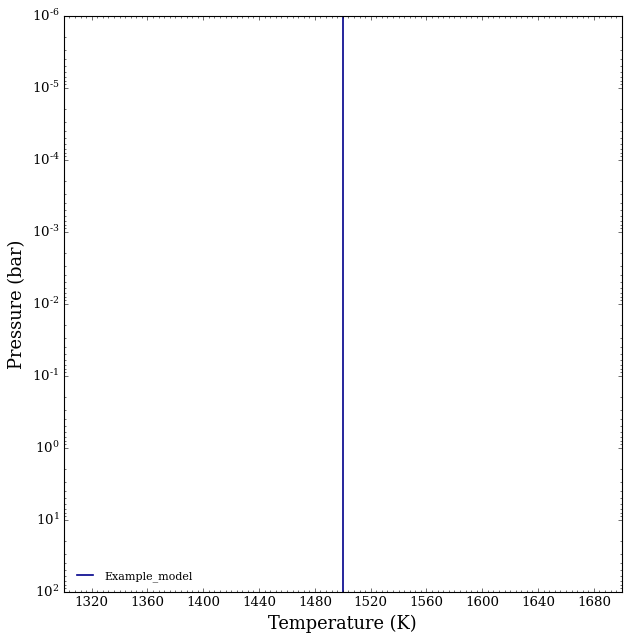

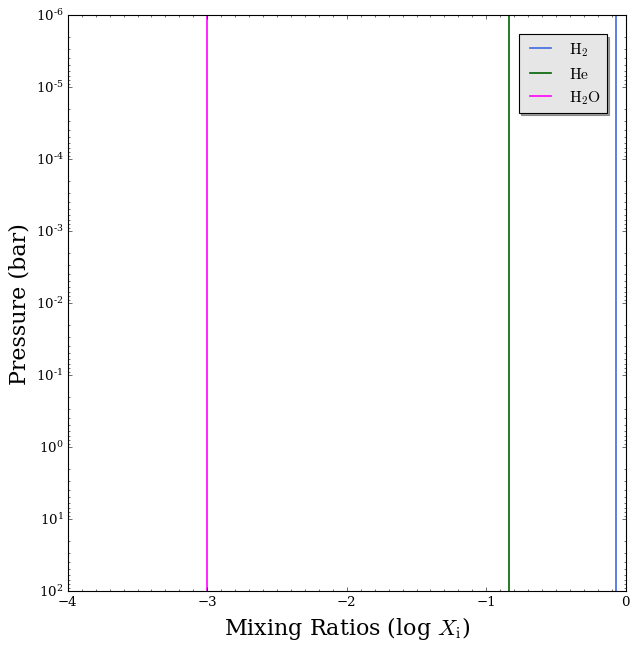

In [5]:
from POSEIDON.visuals import plot_geometry, plot_PT, plot_chem

# Produce plots of atmospheric properties

fig_PT = plot_PT(planet, model, atmosphere)  
fig_chem = plot_chem(planet, model, atmosphere, plot_species = ['H2','He','H2O'])

In [6]:
from POSEIDON.core import read_opacities, wl_grid_constant_R

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 500     # 500 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2500    # 2500 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 3.0    # 1000 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2O done
Opacity pre-interpolation complete.


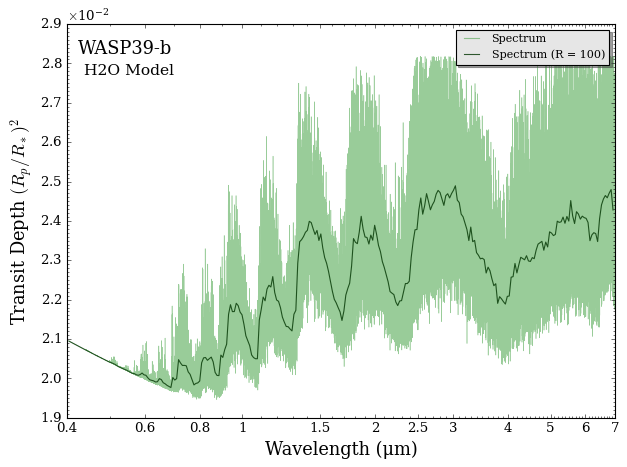

In [41]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate the transmission spectrum
spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                            spectrum_type = 'transmission')

# Add the spectrum we want to plot to an empty spectra plot collection
spectra = plot_collection(spectrum, wl, collection = [])

# Produce figure
fig = plot_spectra(spectra, planet, R_to_bin = 100, plt_label = 'H2O Model')


In [42]:
atmo_data = np.genfromtxt('/home/exolab/GSoC/POS_Data/transit_depth_wasp96b_gau.txt',skip_header=1)
atmo_data.shape

(2864, 2)

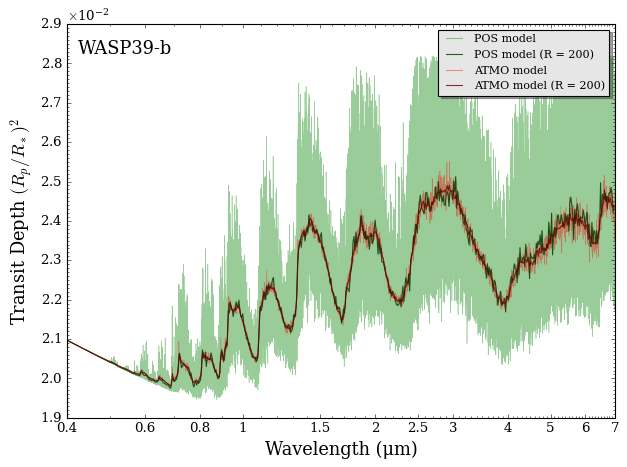

In [40]:
spectrum_new = atmo_data[:,1]
wl_new = atmo_data[:,0]

# Add the spectrum we want to plot to our existing plot collection
spectra = plot_collection(spectrum_new, wl_new, collection = spectra) 

# Produce figure
fig_spec = plot_spectra(spectra, planet, R_to_bin = 200,
                        spectra_labels = ['POS model', 'ATMO model'])

In [47]:

spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                            spectrum_type = 'transmission')

In [55]:
from spectres import spectres
wl_r200 = wl_grid_constant_R(0.4, 7.0, 200)
wl_r200 = wl_r200[1:-1]
pos_binned = spectres(wl_r200,wl,spectrum,verbose=False)
atmo_binned = spectres(wl_r200,wl_new,spectrum_new,verbose=False)

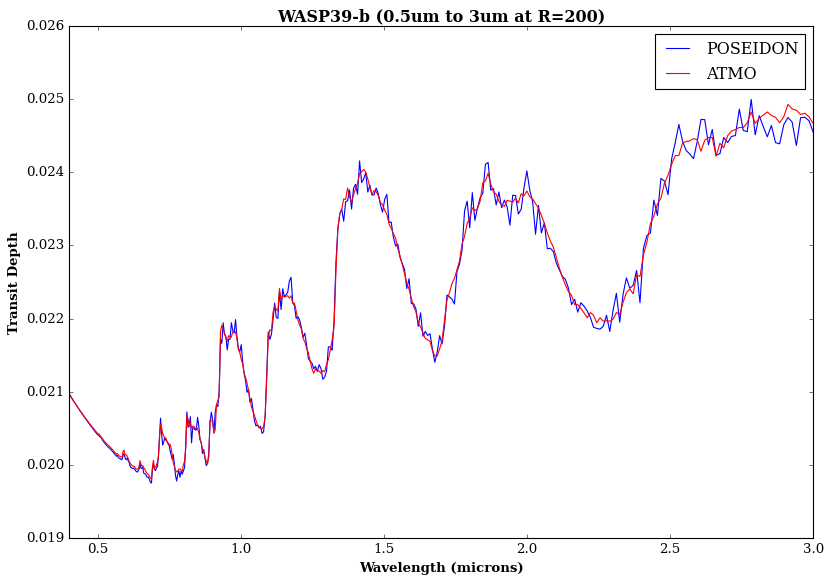

In [72]:
# zoomed view at R=200 
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(12,8))
plt.plot(wl_r200, pos_binned, label='POSEIDON',color='blue')
plt.plot(wl_r200, atmo_binned, label='ATMO',color='red')
plt.legend()
plt.ylabel('Transit Depth',fontweight='bold',fontsize=12)
plt.xlabel('Wavelength (microns)',fontweight='bold',fontsize=12)
plt.xlim(0.4,3)
plt.title('WASP39-b (0.5um to 3um at R=200)',fontweight='bold')
plt.show()

### H3+ Model

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2O done
H3+ done
Opacity pre-interpolation complete.


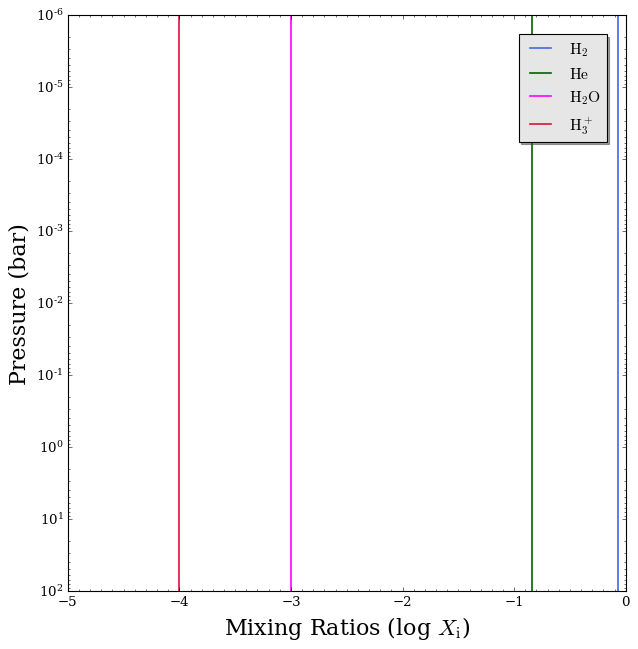

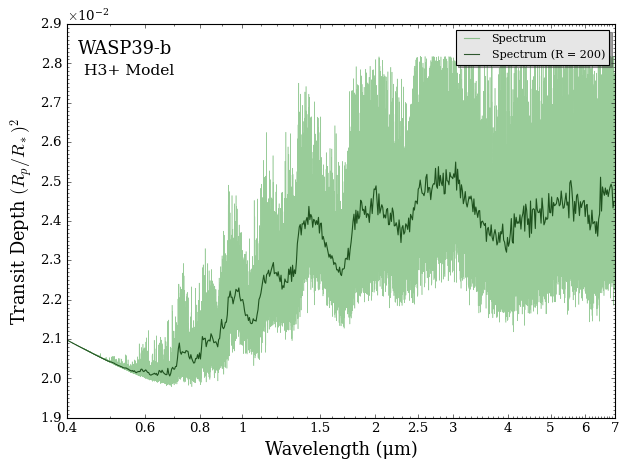

In [74]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'Example_model'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']      # H2 + He comprises the bulk atmosphere
param_species = ['H2O','H3+']          # The trace gas is H2O and H3+

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     PT_profile = 'isotherm', cloud_model = 'cloud-free')

from POSEIDON.core import make_atmosphere
import numpy as np

# Specify the pressure grid of the atmosphere
P_min = 1.0e-6    # 0.1 ubar
P_max = 100      # 100 bar
N_layers = 51    # 51 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 0.01  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere 
PT_params = np.array([1500])              # T (K)
log_X_params = np.array([-3.0,-4.0])     # log(X_i) for H2O and H3+

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                             PT_params, log_X_params)

from POSEIDON.visuals import plot_geometry, plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_chem = plot_chem(planet, model, atmosphere, plot_species = ['H2','He','H2O','H3+'])

from POSEIDON.core import read_opacities, wl_grid_constant_R

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# First, specify limits of the fine temperature and pressure grids for the 
# pre-interpolation of cross sections. These fine grids should cover a
# wide range of possible temperatures and pressures for the model atmosphere.

# Define fine temperature grid (K)
T_fine_min = 500     # 500 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2500    # 2500 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -6.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 3.0    # 1000 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_spectra
from POSEIDON.utility import plot_collection

# Generate our first transmission spectrum
spectrum = compute_spectrum(planet, star, model, atmosphere, opac, wl,
                            spectrum_type = 'transmission')

# Add the spectrum we want to plot to an empty spectra plot collection
spectra = plot_collection(spectrum, wl, collection = [])

# Produce figure and save to file
fig = plot_spectra(spectra, planet, R_to_bin = 200, plt_label = 'H3+ Model')


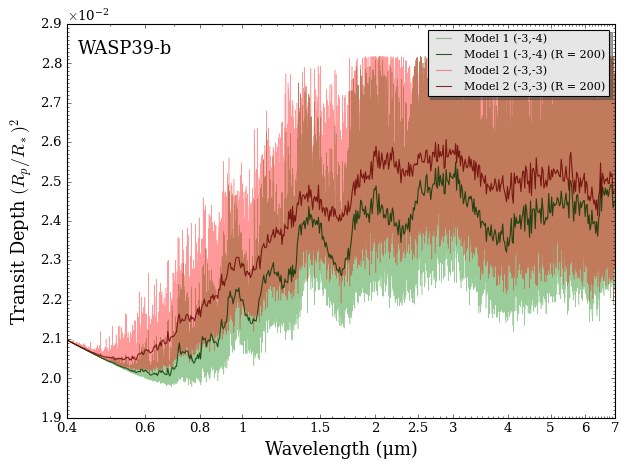

In [75]:
## Trying a different mixing ratio

# Define new mixing ratio array
log_X_params_new = np.array([[-3.0,-3.0]])

# Create a new atmosphere with the new mixing ratios
atmosphere_new = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                                    PT_params, log_X_params_new)

# Generate the new transmission spectrum
spectrum_new = compute_spectrum(planet, star, model, atmosphere_new, 
                                   opac, wl, spectrum_type = 'transmission')

# Add the spectrum we want to plot to our existing plot collection
spectra = plot_collection(spectrum_new, wl, collection = spectra) 

# Produce figure
fig_spec = plot_spectra(spectra, planet, R_to_bin = 200,
                        spectra_labels = ['Model 1 (-3,-4)', 'Model 2 (-3,-3)'])

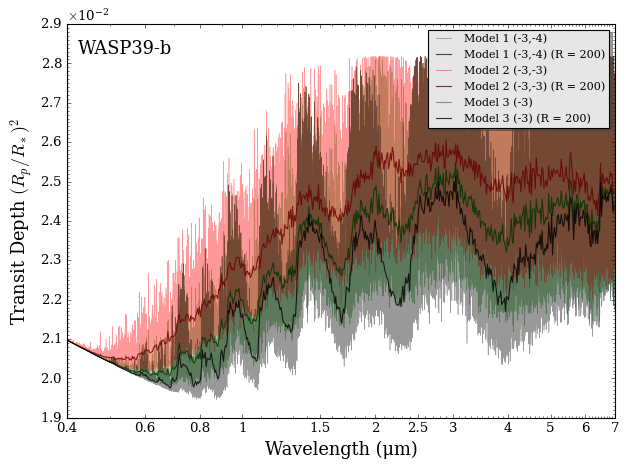

In [76]:
## Adding the only H2O model by keeping the H3+ mixing ratio very low

# Define new mixing ratio array
log_X_params_new = np.array([[-3.0,-20]])

# Create a new atmosphere
atmosphere_new = make_atmosphere(planet, model, P, P_ref, R_p_ref, 
                                    PT_params, log_X_params_new)

# Generate the new transmission spectrum
spectrum_new = compute_spectrum(planet, star, model, atmosphere_new, 
                                   opac, wl, spectrum_type = 'transmission')

# Add the spectrum we want to plot to our existing plot collection
spectra = plot_collection(spectrum_new, wl, collection = spectra) 

# Produce figure
fig_spec = plot_spectra(spectra, planet, R_to_bin = 200,
                        spectra_labels = ['Model 1 (-3,-4)', 'Model 2 (-3,-3)', 'Model 3 (-3)'])